## 3.9　累计与分组
在对较大的数据进行分析时，一项基本的工作就是有效的数据累计（summarization）：计算累计（aggregation）指标，如`sum()`、`mean()`、`median()`、`min()` 和`max()`，其中每一个指标都呈现了大数据集的特征。在这一节中，我们将探索Pandas 的累计功能，从类似前面NumPy 数组中的简单操作，到基于groupby 实现的复杂操作。

In [5]:
import numpy as np
import pandas as pd

### 3.9.1　行星数据
我们将通过Seaborn 程序库（http://seaborn.pydata.org, 详情请参见4.16 节）用一份行星数据来进行演示，其中包含天文学家观测到的围绕恒星运转的行星数据（通常简称为太阳系外行星或外行星）。行星数据可以直接通过Seaborn 下载：

In [2]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [3]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


数据中包含了截至2014 年已被发现的一千多颗外行星的资料。

### 3.9.2　Pandas的简单累计功能
之前我们介绍过NumPy 数组的一些数据累计指标（详情请参见2.4 节）。与一维NumPy 数组相同，Pandas 的Series 的累计函数也会返回一个统计值：

In [6]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

0    0.374540
1    0.950714
2    0.731994
3    0.598658
4    0.156019
dtype: float64

In [7]:
ser.sum()

2.811925491708157

In [8]:
ser.mean()

0.5623850983416314

DataFrame 的累计函数默认对每列进行统计：

In [9]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [10]:
df.mean()

A    0.477888
B    0.443420
dtype: float64

设置axis 参数，你就可以对每一行进行统计了：

In [11]:
df.mean(axis='columns')

0    0.088290
1    0.513997
2    0.849309
3    0.406727
4    0.444949
dtype: float64

Pandas 的Series 和DataFrame 支持所有2.4 节中介绍的常用累计函数。另外，还有一个非常方便的`describe()` 方法可以计算每一列的若干常用统计值。
<br>让我们在行星数据上试验一下，首先丢弃有缺失值的行：

In [12]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


这是一种理解数据集所有统计属性的有效方法。


例如，从年份year 列中可以看出，1989年首次发现外行星，而且一半的已知外行星都是在2010 年及以后的年份被发现的。这主要得益于开普勒计划——一个通过激光望远镜发现恒星周围椭圆轨道行星的太空计划。

表3-3：Pandas的累计方法

|指标|描述|
|:|:|
|count() |计数项|
|first()、last() |第一项与最后一项|
|mean()、median() |均值与中位数|
|min()、max() |最小值与最大值|
|std()、var() |标准差与方差|
|mad() |均值绝对偏差（mean absolute deviation）|
|prod() |所有项乘积|
|sum() |所有项求和|

DataFrame 和Series 对象支持以上所有方法。
<br>但若想深入理解数据，仅仅依靠累计函数是远远不够的。数据累计的下一级别是groupby操作，它可以让你快速、有效地计算数据各子集的累计值。

### 3.9.3　GroupBy：分割、应用和组合
简单的累计方法可以让我们对数据集有一个笼统的认识，但是我们经常还需要对某些标签或索引的局部进行累计分析，这时就需要用到groupby 了。
<br>虽然“分组”（group by）这个名字是借用SQL 数据库语言的命令，但其理念引用发明R 语言frame 的Hadley Wickham的观点可能更合适：分割（split）、应用（apply）和组合（combine）。

#### 3.9.3.1 分割、应用和组合

一个经典分割-应用-组合操作示例如图3-1 所示，其中“apply”的是一个求和函数。

图3-1 清晰地描述了GroupBy 的过程。
* 分割步骤将DataFrame 按照指定的键分割成若干组。
* 应用步骤对每个组应用函数，通常是累计、转换或过滤函数。
* 组合步骤将每一组的结果合并成一个输出数组。

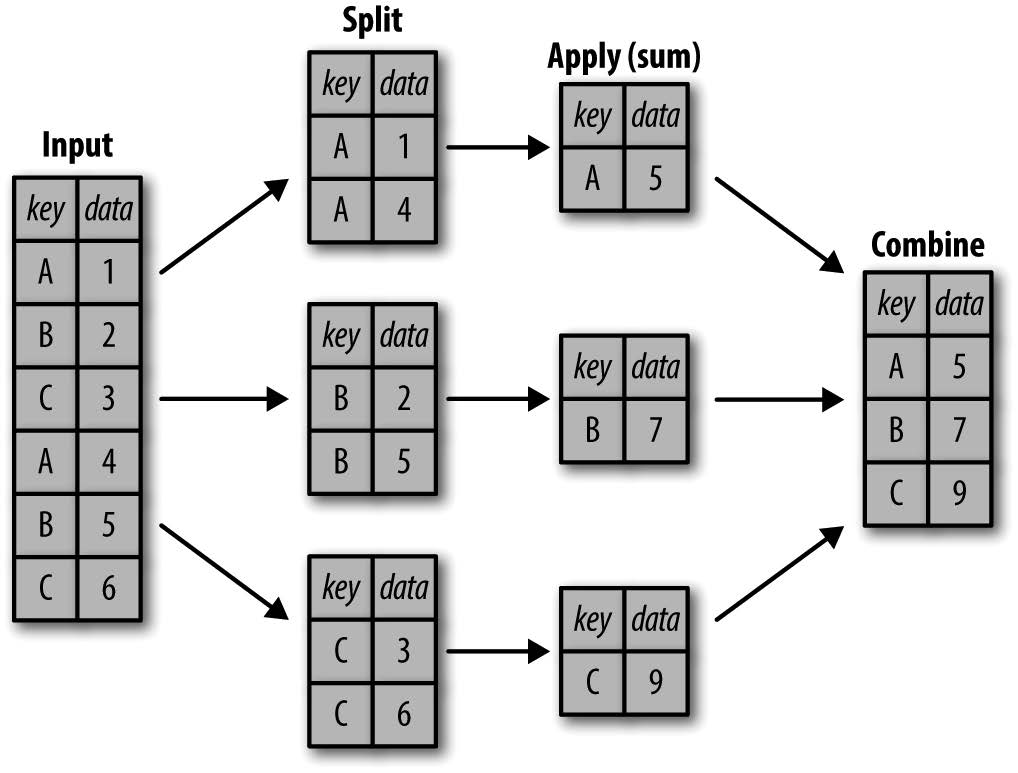

虽然我们也可以通过前面介绍的一系列的掩码、累计与合并操作来实现，但是**意识到中间分割过程不需要显式地暴露出来这一点十分重要**。而且GroupBy（经常）只需要一行代码，就可以计算每组的和、均值、计数、最小值以及其他累计值。GroupBy 的用处就是将这些步骤进行抽象：**用户不需要知道在底层如何计算，只要把操作看成一个整体就够了**。

用Pandas 进行图3-1 所示的计算作为具体的示例。从创建输入DataFrame 开始：

In [14]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


我们可以用DataFrame 的`groupby()` 方法进行绝大多数常见的分割- 应用- 组合操作，将需要分组的列名传进去即可：

In [15]:
df.groupby('key')

需要注意的是，这里的返回值不是一个DataFrame对象，而是一个DataFrameGroupBy对象。这个对象的魔力在于，你可以将它看成是一种特殊形式的DataFrame，里面隐藏着若干组数据，但是在没有应用累计函数之前不会计算。这种“延迟计算”（lazy evaluation）的方法使得大多数常见的累计操作可以通过一种对用户而言几乎是透明的（感觉操作仿佛不存在）方式非常高效地实现。

为了得到这个结果，可以对DataFrameGroupBy对象应用累计函数，它会完成相应的应用/组合步骤并生成结果：

In [16]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


`sum()` 只是众多可用方法中的一个。你可以用Pandas 或NumPy 的任意一种累计函数，也
可以用任意有效的DataFrame 对象。下面就会介绍。

#### 3.9.3.2 GroupBy对象

GroupBy 对象是一种非常灵活的抽象类型。在大多数场景中，你可以将它看成是DataFrame的集合，在底层解决所有难题。让我们用行星数据来做一些演示。

GroupBy 中最重要的操作可能就是aggregate、filter、transform 和apply（累计、过滤、转换、应用）了，后文将详细介绍这些内容，现在先来介绍一些GroupBy 的基本操作方法。

**(1) 按列取值。**

GroupBy 对象与DataFrame 一样，也支持按列取值，并返回一个修改过的GroupBy 对象。

In [17]:
planets.groupby('method')

In [18]:
planets.groupby('method')['orbital_period']

这里从原来的DataFrame 中取某个列名作为一个Series 组。与GroupBy 对象一样，直到我们运行累计函数，才会开始计算：

In [19]:
planets.groupby('method')['orbital_period'].median()

method
Astrometry                         631.180000
Eclipse Timing Variations         4343.500000
Imaging                          27500.000000
Microlensing                      3300.000000
Orbital Brightness Modulation        0.342887
Pulsar Timing                       66.541900
Pulsation Timing Variations       1170.000000
Radial Velocity                    360.200000
Transit                              5.714932
Transit Timing Variations           57.011000
Name: orbital_period, dtype: float64

这样就可以获得不同方法下所有行星公转周期（按天计算）的中位数。

**(2) 按组迭代。**

GroupBy 对象支持直接按组进行迭代，返回的每一组都是Series 或DataFrame：

In [20]:
for (method, group) in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


尽管通常还是使用内置的apply 功能速度更快，但这种方式在手动处理某些问题时非常有用，后面会详细介绍。

**(3) 调用方法。**

借助Python 类的魔力（@classmethod），可以让任何不由GroupBy 对象直接实现的方法直接应用到每一组，无论是DataFrame 还是Series 对象都同样适用。例如，你可以用DataFrame 的describe() 方法进行累计，对每一组数据进行描述性统计：

In [21]:
planets.groupby('method')['year'].describe().unstack()

       method                       
count  Astrometry                          2.000000
       Eclipse Timing Variations           9.000000
       Imaging                            38.000000
       Microlensing                       23.000000
       Orbital Brightness Modulation       3.000000
       Pulsar Timing                       5.000000
       Pulsation Timing Variations         1.000000
       Radial Velocity                   553.000000
       Transit                           397.000000
       Transit Timing Variations           4.000000
mean   Astrometry                       2011.500000
       Eclipse Timing Variations        2010.000000
       Imaging                          2009.131579
       Microlensing                     2009.782609
       Orbital Brightness Modulation    2011.666667
       Pulsar Timing                    1998.400000
       Pulsation Timing Variations      2007.000000
       Radial Velocity                  2007.518987
       Transit             

这张表可以帮助我们对数据有更深刻的认识，例如大多数行星都是通过Radial Velocity和Transit 方法发现的，而且后者在近十年变得越来越普遍（得益于更新、更精确的望远镜）。最新的Transit Timing Variation 和Orbital Brightness Modulation 方法在2011年之后才有新的发现。

这只是演示Pandas 调用方法的示例之一。方法首先会应用到每组数据上，然后结果由GroupBy 组合后返回。另外，任意DataFrame / Series 的方法都可以由GroupBy 方法调用，从而实现非常灵活强大的操作。

#### 3.9.3.3. 累计、过滤、转换和应用

**(1) 累计。**

**(2) 过滤。**

**(3) 转换。**

**(4) apply() 方法。**

#### 3.9.3.4 设置分割的键

**(1) 将列表、数组、Series 或索引作为分组键。**

**(2) 用字典或Series 将索引映射到分组名称。**

**(3) 任意Python 函数。**

**(4) 多个有效键构成的列表。**

#### 3.9.3.5 分组案例